In [7]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pyod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from scipy import stats
import matplotlib as mpl
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from pyod.models.iforest import IForest

In [9]:
root = '/content/drive/MyDrive/Reaps_Final_Submission/'

In [10]:
df = pd.read_csv(root + 'ranchi.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df_temp = df
df_temp['Year'] = pd.DatetimeIndex(df_temp['Datetime']).year

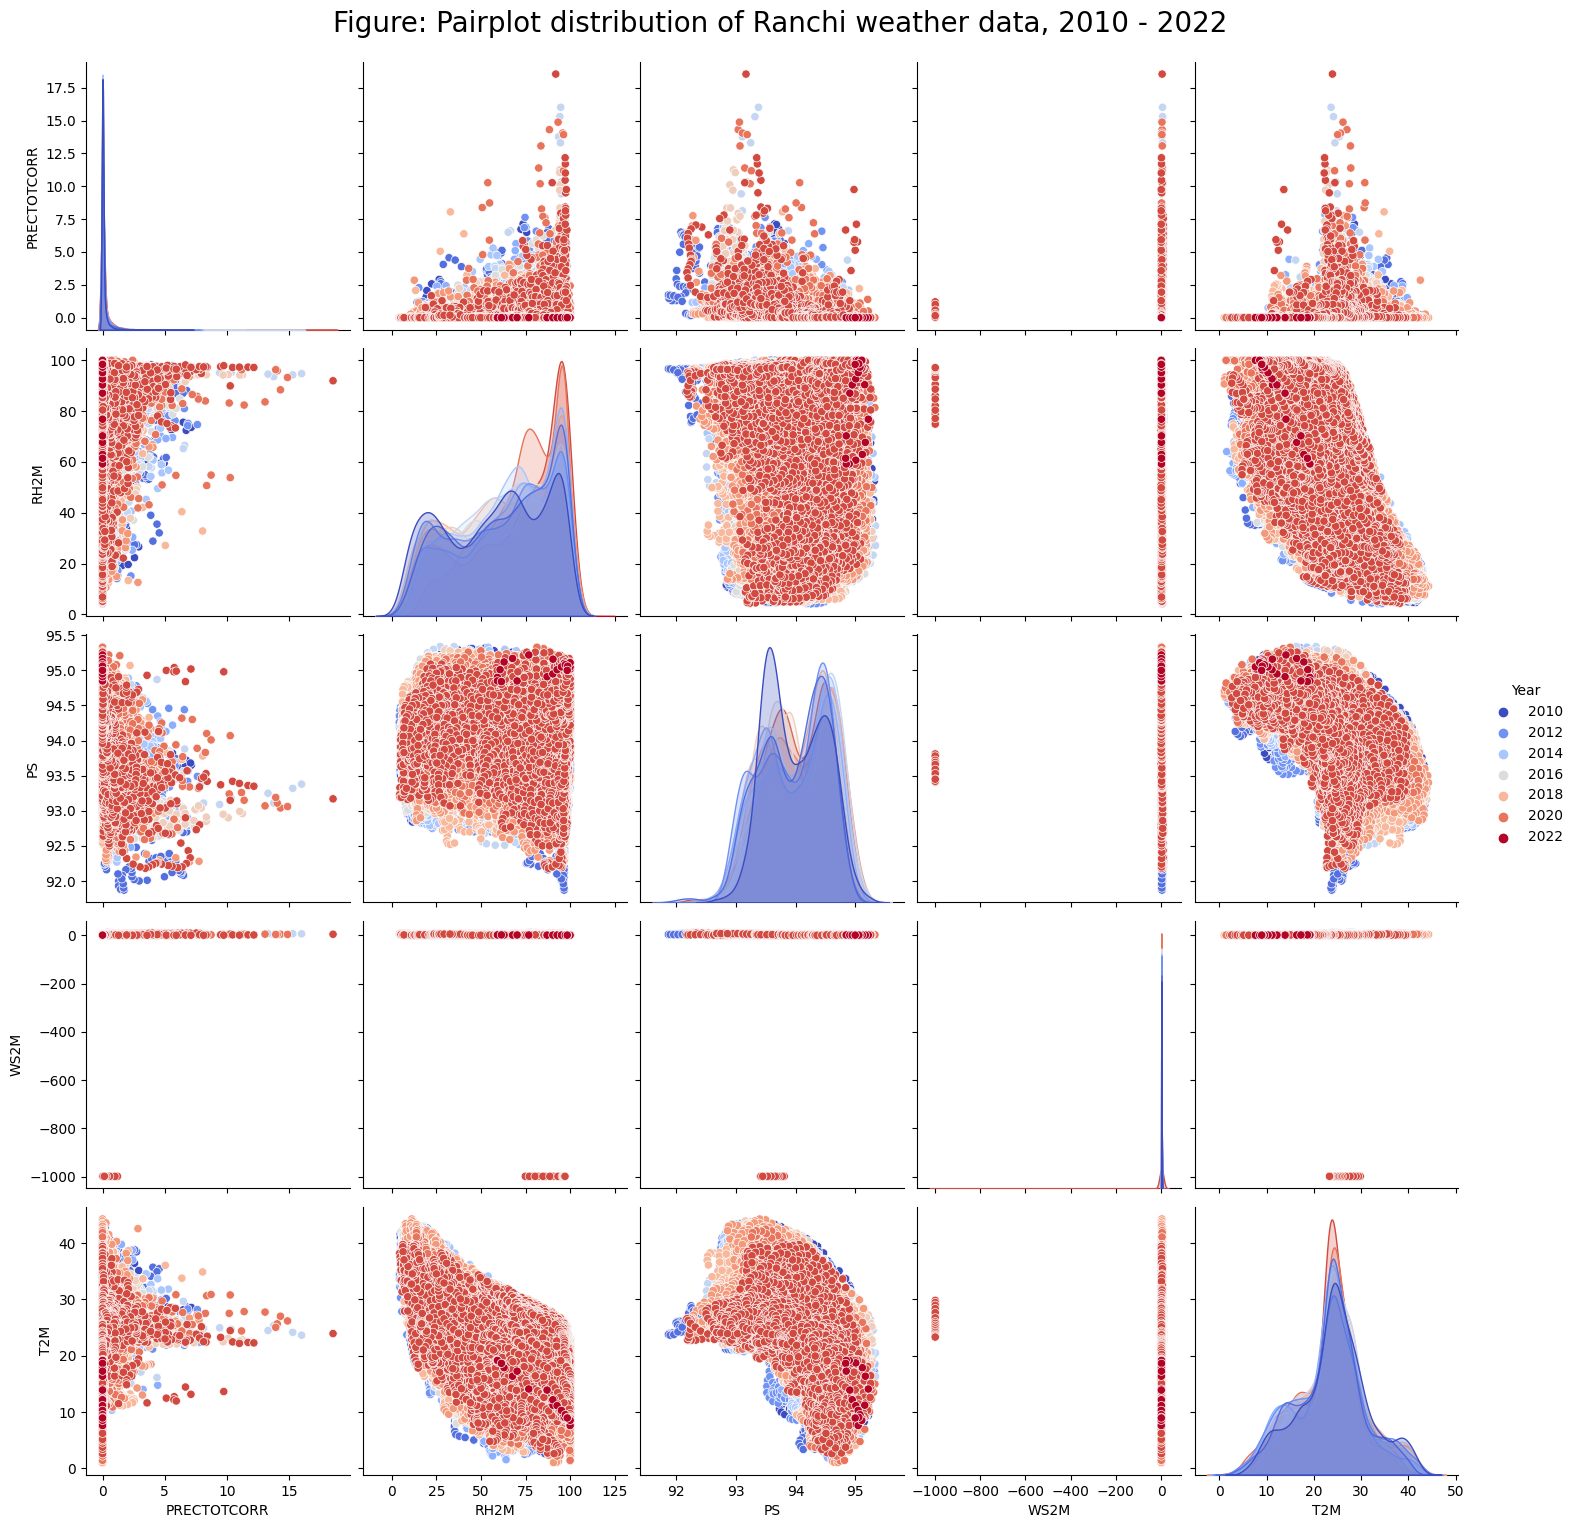

In [11]:
sns.pairplot(
    df_temp,
    height=3,
    vars=[
        "PRECTOTCORR",
        "RH2M",
        "PS",
        "WS2M",
        "T2M",
    ],
    hue="Year",
    palette="coolwarm"
)
plt.suptitle("Figure: Pairplot distribution of Ranchi weather data, 2010 - 2022", fontsize=20, y=1.02)
plt.show()

OUTLIERS: 4209 | INLIERS: 101007 | MODEL: Isolation Forest
Threshold: -1.5220335029212523e-17


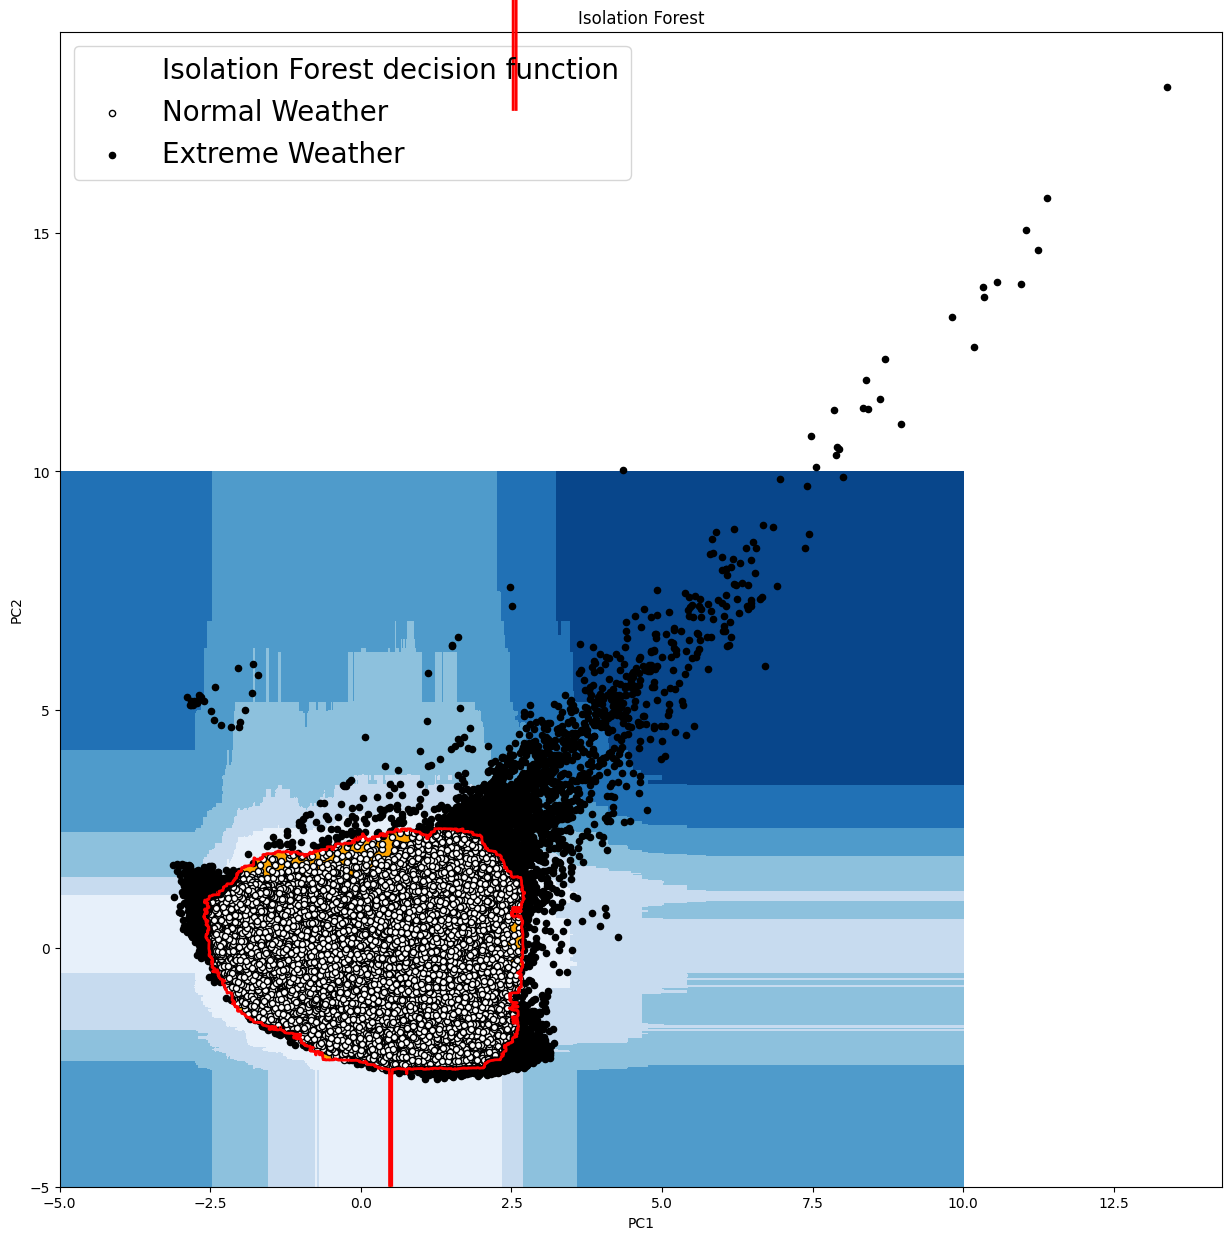

Confusion Matrix:
 [[101007      0]
 [     0   4209]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


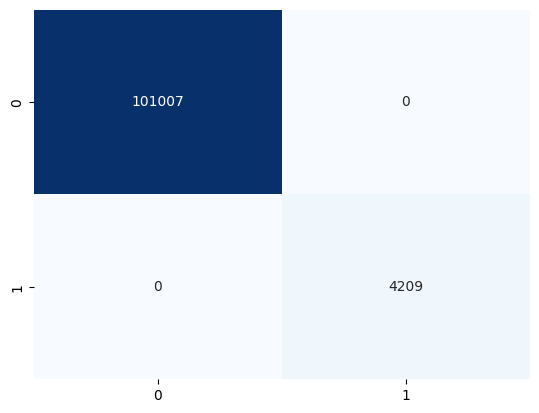

In [28]:
from sklearn.decomposition import PCA

# Select the features for PCA
X_pca = df[['PRECTOTCORR', 'RH2M', 'PS', 'WS2M', 'T2M']]

# Standardize the features
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Perform PCA and select the principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_pca_scaled)

# Create a pandas DataFrame to hold the PCA results
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

X1 = pca_df['PC1'].values.reshape(-1, 1)
X2 = pca_df['PC2'].values.reshape(-1, 1)

X = np.concatenate((X1, X2), axis=1)

outliers_fraction = 0.04

classifiers = {
    "Isolation Forest": IForest(
        contamination=outliers_fraction, random_state=42, behaviour="new"
    )
}

# Define the grid for anomaly scores
xx , yy = np.meshgrid(np.linspace(-5, 10, 2000), np.linspace(-5, 10, 2000))

# Initialize a list to hold the outliers
outliers = []

# Loop through the classifiers
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    
    scores_pred = clf.decision_function(X) * -1
        
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(15, 15))
    
    pca_df_2 = pca_df.copy()
    pca_df_2['outlier'] = y_pred.tolist()
    
    outliers.append(pca_df_2.loc[pca_df_2['outlier'] == 1])
    outliers_df = pd.concat(outliers) 
    
    IN1 =  np.array(pca_df_2['PC1'][pca_df_2['outlier'] == 0]).reshape(-1,1)
    IN2 =  np.array(pca_df_2['PC2'][pca_df_2['outlier'] == 0]).reshape(-1,1)
     
    
    OUT1 =  pca_df_2['PC1'][pca_df_2['outlier'] == 1].values.reshape(-1,1)
    OUT2 =  pca_df_2['PC2'][pca_df_2['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS:',n_outliers, '|', 'INLIERS:',n_inliers, '|', 'MODEL:',clf_name)
        
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
           
    b = plt.scatter(IN1,IN2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OUT1,OUT2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['Isolation Forest decision function', 'Normal Weather','Extreme Weather'],
        prop=mpl.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.axis('tight')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    print('Threshold:', threshold)
    plt.title(clf_name)
    plt.show()

    y_true = np.zeros(len(pca_df))
    y_true[outliers_df.index] = 1

    y_pred = clf.predict(X)

    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

    print("Confusion Matrix:\n", cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)